In [1]:
import nlp
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

In [2]:
# train_path = "D:/project/dataset/patent/b/data000000000001.json"

# df = pd.read_json(train_path,lines=True)

# df = df.rename(columns={"description": "input_text", "abstract": "target_text"})
# df = df.dropna()
# df.head()
raw_data = nlp.load_dataset('cnn_dailymail', '3.0.0', split='train[:1%]')
df = pd.DataFrame(raw_data)
df.head()

,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA ""virtual"" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years. Under the program, ...","The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting program, like all GSA practices, is under review .",00027e965c8264c35cc1bc55556db388da82b07f
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him as part of a team of doctors. Dr. Blaga Stancheva, a family physician and specialist in obstetrics, said both Burkhart and his mother, Dorothee, were her patients in Vancouver while both were applying for refugee status in Canada. ""I was asked to diagnose and treat Harry to support a claim explaining why he was unable to show up in a small-claims court case,"" Stancheva told CNN in a phone intervie...","NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression""\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .",0002c17436637c4fe1837c935c04de47adb18e9a
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18, was arrested on charges of felony rape, rape in concert with force, and penetration with a foreign object, said Richmond Police L

In [3]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.configuration_bart.BartConfig,
 transformers.tokenization_bart.BartTokenizer,
 transformers.modeling_bart.BartForConditionalGeneration)

In [4]:
hf_batch_tfm = HF_SummarizationBatchTransform(hf_arch, hf_tokenizer, max_length=[256, 130])

blocks = (HF_TextBlock(hf_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())

In [12]:
dls = dblock.dataloaders(df, bs=2,num_workers=0)

In [13]:
len(dls.train.items), len(dls.valid.items)

(2297, 574)

In [14]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 68]))

In [15]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"The news from Pakistan is generally bad news. In the past week, which was far from atypical, suicide bombers attacked a court building in the northwestern city of Peshawar taking hostages and killing four people. In the southern city of Karachi the director of a renowned social program working in the megacity's poorest neighborhoods was shot and killed. And gunmen kidnapped two female Czech tourists in southwestern Pakistan. But this past week also saw more than a glimmer of good news from Pakistan: Saturday, March 16 marked an extraordinary moment in Pakistani history, as this is the first time a civilian government has served its entire five-year term (from 2008 to 2013). And, for the first time in its history, the Pakistani military appears unwilling to mount a coup against the civilian government. The military has successfully executed three coups and attempted a number of others since Pakistan's independence in 1947. Today the army understands that the most recent coup by General Pervez Musharraf who took power in 1999 has tarnished its brand. Musharraf hung on to power for almost a decade and his imposition of emergency rule in 2007 triggered massive street protests and eventually his ouster. On Saturday, Musharaf announced he is returning to Pakistan from self-imposed exile on March 24 to","Peter Bergen: For the first time, Pakistan government served its full term.\nHe says lack of military coup attempt shows government is more stable than many think.\nElections in Pakistan, Afghanistan likely to be crucial for those two nations.\nBergen: He says Afghan economy is resilient and corruption may be receding."
1,"(CNN) -- The generation of gays and lesbians that literally created the modern LGBT movement -- from the heroes of the 1969 Stonewall riots to their slightly younger friends -- is at, or nearing, retirement age. That used to mean the beginning of an extremely difficult time in an LGBT person's life. But as gay baby boomers find more acceptance in mainstream society and continue to do what they've always done -- push to make a better world for the LGBT community -- their retirement options are slowly improving. That is, if they decide to retire at all. ""The notion of retirement has never been a part of my vocabulary,"" said Bob Witeck, CEO and co-founder of Witeck Communications. Nearly 61, Witeck has put some thought into what he should do with his strategic public relations and marketing firm as he gets older. Like many friends his age who are also entrepreneurs, he plans to keep working. ""Because I run a business, as I get older I can change the intensity of my engagement in the kinds of work I take on,"" Witeck said. ""I know I'm lucky that way, and I'm lucky in my personal life as well. My husband is 50, so I have a younger man to help me","LGBT baby boomers changed the visibility of the gay community.\nAs they approach retirement, they face different obstacles than their straight counterparts.\nWithout marriage equality, same-sex couples may face financial hardships.\nAdvocates say the situation is slowly improving."


In [16]:
text_gen_kwargs = { **hf_config.task_specific_params['summarization'], **{'max_length': 130, 'min_length': 30} }
text_gen_kwargs

{'length_penalty': 1.0, 'max_length': 130, 'min_length': 30, 'num_beams': 4}

In [17]:
model = HF_BaseModelWrapper(hf_model)
model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=HF_MaskedLMLoss(),
                cbs=[model_cb],
                splitter=partial(summarization_splitter, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=6.309573450380412e-07)

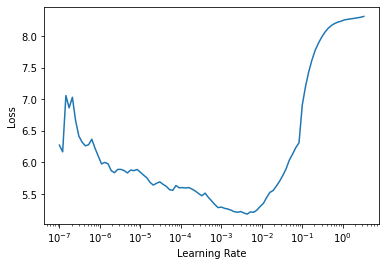

In [18]:
learn.lr_find(suggestions=True)


In [19]:
b = dls.one_batch()
print(b)
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

({'input_ids': tensor([[    0,    20,   340,    31,  1752,    16,  3489,  1099,   340,     4,
            96,     5,   375,   186,     6,    61,    21,   444,    31,    23,
         18198,  3569,     6,  4260, 20824,  4487,    10,   461,   745,    11,
             5, 22402,   343,     9, 24307, 20373,   602, 26445,     8,  2429,
           237,    82,     4,    96,     5,  3174,   343,     9, 15043,     5,
           736,     9,    10, 12086,   592,   586,   447,    11,     5, 10721,
         18583,    18, 19125,  9100,    21,   738,     8,   848,     4,   178,
         18282, 15762,    80,  2182,  9096,  6349,    11, 20431,  1752,     4,
           125,    42,   375,   186,    67,   794,    55,    87,    10,  5921,
         15912,     9,   205,   340,    31,  1752,    35,   378,     6,   494,
           545,  4760,    41,  7116,  1151,    11,  9246,   750,     6,    25,
            42,    16,     5,    78,    86,  1437,    10,  8233,   168,    34,
          1665,    63,  1445,   292, 

(3,
 tensor(5.4538, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 67, 50265]))

In [20]:
learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,2.967004,2.646416,0.334397,0.119666,0.223722,10:37


In [21]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"Washington (CNN) -- New details emerged of what the White House knew about the Internal Revenue Service targeting of conservative groups, with spokesman Jay Carney disclosing Chief of Staff Denis McDonough was among the top officials made aware of the matter late last month. In a new timeline provided by Carney to reporters on Monday, General Counsel Kathryn Ruemmler learned on April 24 of a pending Treasury inspector general's report on how IRS staff used criteria targeting conservative groups in assessing eligibility for tax-exempt status. According to Carney, Ruemmler told McDonough as well as other Treasury officials about the pending report. It was the first time the White House acknowledged that McDonough was aware of the report before it became public in early May. IRS: By the numbers. In addition, Carney made clear that the information Ruemmler received on April 24 included details of improper acts by IRS officials. At the same time, Carney emphasized that the information was preliminary and could have changed before the inspector general released his final report on May 14. Carney insisted no one -- including Ruemmler and McDonough -- told President Barack Obama anything about the inspector general's pending report before media reports about it began appearing on May 10. ""We knew the subject of the investigation",A Senate committee holds a hearing Tuesday on the IRS targeting.\nWhite House discloses new details of what it knew about the IRS targeting report.\nWhite House spokesman says President Obama wasn't told of the pending report.\nNEW: First lawsuit filed over IRS targeting.,"NEW: Carney says White House knew about IRS targeting of conservative groups .\nCarney: ""We knew the subject of the report before it became public""The White House says the inspector general's report was preliminary and could have changed before it released his final report on May 14 ."
1,"NEW YORK (CNN) -- Richard Serra stands in the Museum of Modern Art's Abby Aldrich Rockefeller Sculpture Garden, his hair as white as the marble floor. The summer sun of New York radiates from the towering metal of his monumental works. He breaks no sweat. He likes how the weeping beeches and birches have leafed out since April when two of his enormous steel sculptures were installed. A crane lifted the tonnage over the garden wall from West 54th Street. This new foliage, he notes, shades his works' rising, rusting arcs with an air of mystery. ""You can't see 'Ellipse' from 'Intersection.' So as you walk out of one, you're not thinking about the other."" What you're thinking about may be their size. ""Intersection II"" is more than 13 feet tall and 51 feet long. ""Torqued Ellipse IV"" at one point is 32 feet across. Made to be entered, explored, felt in terms of how they divide and define space around you, these gentle, giant landmarks of a 40-year career place Serra today at the very heart of the Museum of Modern Art's mission and capabilities. Watch videos in which Serra",'Richard Serra Sculpture: Forty Years' runs to September 10 at MoMA.\nMore than 800 tons of monumental steel and free-standing lead constructions.\nMoMA's Abby Aldrich Rockefeller Sculpture Garden one of three venues.\nCranes required to hoist steel sections over garden wall and into galleries.,"The Serra stands in the Museum of Modern Art's Abby Aldrich Rockefeller Sculpture Garden, his hair as white as the marble floor. The summer sun of New York radiates from the towering metal of his monumental works. He breaks no sweat. He likes how the weeping beeches and birches have leafed out since April when two of his enormous steel sculptures were installed. A crane lifted the tonnage over the garden wall from West 54th Street. This new foliage, he notes, shades his works' rising, rusting arcs with an air of mystery. Serra says, ""I'm not thinking about the"
